In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [23]:
#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

In [24]:
#loading code modules containing some of the routines we wrote last time
#... so we don't have to write them again here! this is called "code reuse" :)

import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)


<module 'cross_validation' from 'cross_validation.pyc'>

In [25]:
#ok let's load our usual data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [26]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]


In [27]:
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())


In [28]:
#now, let's actually import the Linear Support Vector Classifier (LinearSVC)
#from scikit
from sklearn.svm import LinearSVC

In [29]:
cat1 = 'Faces'
cat2 = 'Fruits'

results_svm_default = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2]),
                        test_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2])
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                              )
    results_svm_default[vl] = results
    print('SVM Classifier Default Regulazation Var level %s performance on %s vs %s: %.2f%%' % (vl,   
                                                                           cat1,
                                                                           cat2,
                                                                           100*results['test']['mean_accuracy']))



SVM Classifier Default Regulazation Var level V0 performance on Faces vs Fruits: 100.00%
SVM Classifier Default Regulazation Var level V3 performance on Faces vs Fruits: 95.75%
SVM Classifier Default Regulazation Var level V6 performance on Faces vs Fruits: 77.00%


In [30]:
#Let's do a bit more regularization (lower C)


results_l2_svm = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2]),
                        test_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2])
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': 5e-3}  ##HERE'S WHERE THE REGULARIZATION 
                                                                       ##PARAMETER IS INJECTED
                                                                       ##NB This C is proportional to 1 / lambda
                                                                       ##So small C is MORE regularization 
                                              )
    results_l2_svm[vl] = results
    print('L2 Regularized SVM Classifier Var level %s performance on %s vs %s: %.2f%%' % (vl,   
                                                                           cat1,
                                                                           cat2,
                                                                           100*results['test']['mean_accuracy']))

#So actually, doing somewhat less than the default (C=1) is better for results

L2 Regularized SVM Classifier Var level V0 performance on Faces vs Fruits: 100.00%
L2 Regularized SVM Classifier Var level V3 performance on Faces vs Fruits: 96.63%
L2 Regularized SVM Classifier Var level V6 performance on Faces vs Fruits: 80.50%


In [31]:
#now let's look at this for 8-way tasks not just binary
#first with default regularization ... 

results_svm_classifier_8way = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl),
                        test_filter=lambda x: (x['variation_level'] == vl)
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC
                                              )
    results_svm_classifier_8way[vl] = results
    print('SVM Classifier Var level %s performance 8-way: %.2f%%' % (vl,
                                                                     100*results['test']['mean_accuracy']))

for vl in ['V0', 'V3', 'V6']:
    print('SVM Classifier Var level %s test performance 8-way: %.2f%%' % (vl,
                            100*results_svm_classifier_8way[vl]['test']['mean_accuracy']))
    
    print('SVM Classifier Var level %s train performance 8-way: %.2f%%' % (vl,
                            100*results_svm_classifier_8way[vl]['train']['mean_accuracy']))

#so the key observation is that the more heavily regularized L2 classifier has lower train performance
#but higher test performance -- better generalization -- which is what matters!

SVM Classifier Var level V0 performance 8-way: 91.69%
SVM Classifier Var level V3 performance 8-way: 77.72%
SVM Classifier Var level V6 performance 8-way: 54.66%
SVM Classifier Var level V0 test performance 8-way: 91.69%
SVM Classifier Var level V0 train performance 8-way: 100.00%
SVM Classifier Var level V3 test performance 8-way: 77.72%
SVM Classifier Var level V3 train performance 8-way: 99.81%
SVM Classifier Var level V6 test performance 8-way: 54.66%
SVM Classifier Var level V6 train performance 8-way: 87.02%


In [32]:
#... now again with more regularization (lower C)

l2_results_svm_classifier_8way = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl),
                        test_filter=lambda x: (x['variation_level'] == vl)
                       )

    results, train_classes = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args = {'C': 5e-3} 
                                              )
    l2_results_svm_classifier_8way[vl] = results
    print('More L2-Regularized SVM Classifier Var level %s test performance 8-way: %.2f%%' % (vl,
                                                                           100*results['test']['mean_accuracy']))
    
    print('More L2-Regularized SVM Classifier Var level %s train performance 8-way: %.2f%%' % (vl,
                                                                           100*results['train']['mean_accuracy']))

More L2-Regularized SVM Classifier Var level V0 test performance 8-way: 93.12%
More L2-Regularized SVM Classifier Var level V0 train performance 8-way: 100.00%
More L2-Regularized SVM Classifier Var level V3 test performance 8-way: 84.62%
More L2-Regularized SVM Classifier Var level V3 train performance 8-way: 95.17%
More L2-Regularized SVM Classifier Var level V6 test performance 8-way: 60.94%
More L2-Regularized SVM Classifier Var level V6 train performance 8-way: 81.19%


In [33]:
#ok so the interesting thing to notice about is that while with less regularization
#training performance increases (e.g. 86.96% vs 81.19%) testing performance is worse 
#(54.44% vs 60.95%) -- so regularization can help prevent overfitting!

In [41]:
#also, compare to the minimum distance classifier from the last lecture -- performance is really 
#much better here (e.g. ~61% vs ~43% there)

## Systematically comparing across different regularization values

In [34]:
#Let's compare what happens to the weights at different values of the regularization

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        1,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

results_defaultC, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': 1},
                                               return_models=True
                                              )

results_lowC, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C':5e-3},
                                               return_models=True
                                              )

results_hiC, _ig = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C':5e3},
                                               return_models=True
                                              )

trained_model_defaultC = results_defaultC['models'][0]
trained_model_lowC = results_lowC['models'][0]
trained_model_hiC = results_hiC['models'][0]

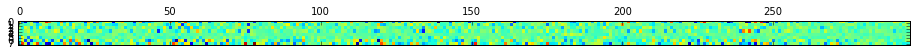

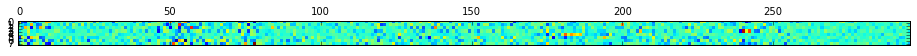

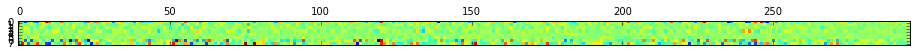

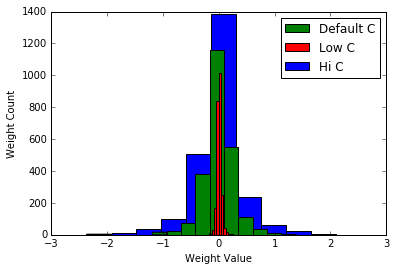

In [35]:
weights_defaultC = trained_model_defaultC.coef_
plt.matshow(weights_defaultC)

plt.figure()
weights_lowC = trained_model_lowC.coef_
plt.matshow(trained_model_lowC.coef_)

plt.figure()
weights_hiC = trained_model_hiC.coef_
plt.matshow(trained_model_hiC.coef_)


plt.figure()
l2 = plt.hist(weights_hiC.ravel(), bins=10);
l0 = plt.hist(weights_defaultC.ravel(), bins=10);
l1 = plt.hist(weights_lowC.ravel(), bins=10);
plt.legend([l0[2][0], l1[2][0], l2[2][0]], ['Default C', 'Low C', 'Hi C'])
plt.xlabel('Weight Value')
plt.ylabel('Weight Count')

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        1,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       ) 

#the weights of the low C (more heavily regularized) classifier are more close to 0
#while weights of the hi C (more heavily regularized) classifier are more larger
# ... as expected

In [36]:
#Let's look at performance (training AND testing) as a function of regularization constant
splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        5,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

cvals = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 
         1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

def get_C_curve():
    results = {}
    for cval in cvals:
        print('Getting results for cval=%f' % cval)
        results[cval] = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               model_args={'C': cval}
                                              )
    return results

In [37]:
results_C_curve = get_C_curve()

Getting results for cval=0.000000
Getting results for cval=0.000000
Getting results for cval=0.000001
Getting results for cval=0.000010
Getting results for cval=0.000100
Getting results for cval=0.001000
Getting results for cval=0.010000
Getting results for cval=0.100000
Getting results for cval=1.000000
Getting results for cval=10.000000
Getting results for cval=100.000000
Getting results for cval=1000.000000
Getting results for cval=10000.000000
Getting results for cval=100000.000000
Getting results for cval=1000000.000000
Getting results for cval=10000000.000000
Getting results for cval=100000000.000000


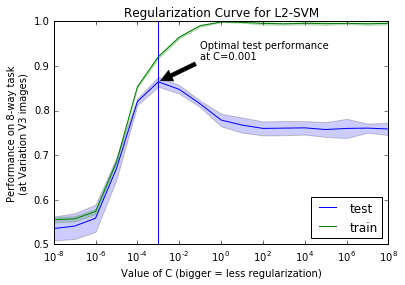

In [38]:
test_acc_curve = np.array([np.mean(results_C_curve[_cv][0]['test']['accuracy_by_split']) for _cv in cvals])
test_acc_std = np.array([np.std(results_C_curve[_cv][0]['test']['accuracy_by_split']) for _cv in cvals])

l0 = plt.semilogx(cvals, test_acc_curve)
plt.fill_between(cvals, test_acc_curve - test_acc_std, test_acc_curve + test_acc_std, alpha=.2)

optimal = test_acc_curve.argmax()
plt.axvline(cvals[optimal])
plt.annotate('Optimal test performance\nat C=%.3f' % cvals[optimal], 
             xy=(cvals[optimal], test_acc_curve[optimal]),
             xytext=(cvals[optimal]+.1, test_acc_curve[optimal]+.05),
             arrowprops=dict(linewidth=0.5, facecolor='black', shrink=0.05))
    

train_acc_curve = np.array([np.mean(results_C_curve[_cv][0]['train']['accuracy_by_split']) for _cv in cvals])
train_acc_std = np.array([np.std(results_C_curve[_cv][0]['train']['accuracy_by_split']) for _cv in cvals])

l1 = plt.semilogx(cvals, train_acc_curve)
plt.fill_between(cvals, train_acc_curve - train_acc_std, train_acc_curve + train_acc_std, alpha=.2, color='g')

plt.xlabel('Value of C (bigger = less regularization)')
plt.ylabel('Performance on 8-way task\n(at Variation V3 images)')
plt.legend([l0[0], l1[0]], ['test', 'train'], loc='lower right')
plt.title('Regularization Curve for L2-SVM')

#OK, we see that
#  (1) training and testing are both poor at very high levels of regularization (low C)
#  (2) training performance increases monotonically as regularization decreases, 
#      converging to ceiling levels at very high values of C
#  (3) overfitting (gap between green and blue) increases as regularization decreases
#  (4) most important: there is an *optimal* level of regularization from a testing perspective

### Cross-Validating your regularization parameter

In [39]:
#let's use the built-in GridSearch facility to make it easy to do
#search for the C parameter

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        2,  
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

#ok notice that now instead of passing model_args#
#we're passing gridcv_params
gridCV_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LinearSVC,
                                 gridcv_params={'C': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 
                                                      1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 
                                                      1e3, 1e4, 1e5, 1e6, 1e7, 1e8]},
                                 return_models=True
                                 )

In [40]:
#OK, how well do this do?
acc = gridCV_res[0]['test']['mean_accuracy']
print("Cross-validated search for C value accuracy: %.2f%%" % (100 * acc))
#ok not bad!
#And what value of C did it come up with? 
chosen_cvals = [_m.best_estimator_.C for _m in gridCV_res[0]['models']]
print('Chosen cvals:', chosen_cvals)
#Ah, it found the same one we did (1e-3) on both splits we tried

Cross-validated search for C value accuracy: 85.94%
('Chosen cvals:', [0.001, 0.001])
